In [ ]:
#| default_exp mfpt

# Mean First Passage Times in 1D and 2D environments
This notebook contains exploratory work developed within the project to understand how MFPT worked from a theoretical perspective. This results were finally not published and then should be considered as final.

In [3]:
#| export
import numpy as np
from tqdm.notebook import tqdm, trange
from tqdm import tqdm as tqdm_term
from typing import Callable

from rl_opts.analytics import pdf_powerlaw, pdf_discrete_sample

In [ ]:
#| export
# This package is not included in the requirements and should be installed by hand
from joblib import Parallel, delayed

In [6]:
#| hide
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import matplotlib.colors as mcolors

## 1D 

In [1]:
#| export
def constant_velocity_generator(N, # Number of trajectories
                                T, # Length of trajectories
                                time_sampler, # Sampler of time of constant velocity
                                velocity = 1, # Velocity
                                **sample_args # Optional arguments for the sampler
                               ):
    ''' Given a sampler for length of time steps, generates a trajectory considering a constant
    velocity in the sampled times. After each time step, we sample a new direction. '''
    
    trajs = np.zeros((N, T))
    
    for idxN in (range(N)):        
        
        times = time_sampler(num_samples = T+1, **sample_args).astype(int)
        
        max_t = np.argwhere(np.cumsum(times) > T+1).flatten()
        if len(max_t) > 0:
            max_t = max_t[0]
        else: max_t = T+1
        
        traj = np.array([0])
        cumsum = 0
        for time in times[:max_t+1]:
            segment = (2*np.random.randint(0, 2)-1)*np.arange(1, min(time+1, T+1))+traj[-1]
            
            traj = np.append(traj, segment)
            cumsum += len(segment)
            if cumsum > T:
                break

        trajs[idxN] = traj[:T]
        
    return trajs
    

In [7]:
N = 5; T = 150

trajs_lw = constant_velocity_generator(N,
                                       T, 
                                       time_sampler = pdf_discrete_sample, 
                                       pdf_func=pdf_powerlaw,
                                       L_max = T,                                       
                                       beta = 1)

def single_steps(num_samples):
    return np.ones(num_samples)

trajs_rw = constant_velocity_generator(N, T, time_sampler = single_steps, velocity = 1.2)


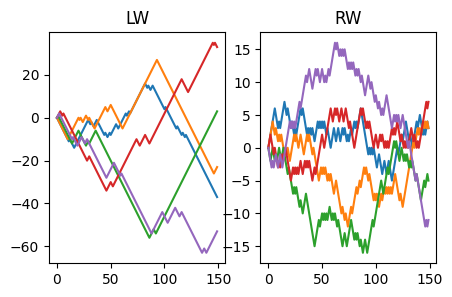

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (5,3))
ax[0].plot(trajs_lw.transpose())
ax[0].set_title('LW')
ax[1].plot(trajs_rw.transpose())
ax[1].set_title('RW');

### MFPT calculators

#### Uniformed

In [20]:
#| export
from typing import Callable

def mfpt_rw(N:int, # Number of trajectories
            T:int, # Lengths of trajectories
            x0:float, # Starting point of walk
            Ls:list, # Boundary position
            traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
            max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
            save = None,
            **args_generator # Arguments of the trajectory generator
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 '''
    
    trajs = traj_generator(N,T,**args_generator) + x0
    
    if save is not None:
        statistics_fpt = np.zeros((len(Ls), N))

    mfpt = []
    for idxL, L in tqdm_term(enumerate(Ls)):   
        first_passage = np.argmax((trajs < 0) | (trajs > L), axis = 1) 

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = trajs[non_passed, -1]
        while len(non_passed) > 0 and n_loop < max_loop:
            
            trajs_upd = traj_generator(len(non_passed),T,**args_generator) + last_non_passed[..., np.newaxis]
            
            # Finding the FPT of the new trajectories
            first_upd = np.argmax((trajs_upd < 0) | (trajs_upd > L), axis = 1)            
            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = trajs_upd[upd_non_passed, -1]
            # updating loop num
            n_loop += 1      
                                  
        if save is not None:
            statistics_fpt[idxL] = first_passage.copy()
                                

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
        
        
    if save is not None:
        np.save(save+'.npy', mfpt)
        np.save(save+'_stats.npy', statistics_fpt)
        
    return mfpt

#### Informed

In [21]:
#| export
def mfpt_informed_rw(N:int, # Number of trajectories
            T:int, # Lengths of trajectories
            x0:float, # Starting point of walk
            Ls:list, # Boundary position
            traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
            max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
            time_sampler = None,
            save = None,
            **args_generator # Optional                     
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 with a traj generator informed on the scales of the sysmte (x0 and L)'''
    
    if save is not None:
        statistics_fpt = np.zeros((len(Ls), N))

    mfpt = []
    for idxL, L in tqdm_term(enumerate(Ls)):  
        
        trajs = traj_generator(N, T, time_sampler = time_sampler, x0 = x0, L = L, informed = True)
        
        first_passage = np.argmax((trajs < 0) | (trajs > L), axis = 1) 

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        while len(non_passed) > 0 and n_loop < max_loop:
            last_non_passed = trajs[non_passed, -1]
            trajs_upd = traj_generator(len(non_passed),T, 
                                       time_sampler = time_sampler, x0 = x0, L = L, 
                                       informed = True) + last_non_passed[..., np.newaxis]

            # updating trajectories with new positions. This makes that last_non_passed is always correct
            trajs[non_passed, -1] = trajs_upd[:, -1]
            # Finding the FPT of the new trajectories
            first_upd = np.argmax((trajs_upd < 0) | (trajs_upd > L), axis = 1)            
            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating loop num
            n_loop += 1      
                                  
        if save is not None:
            statistics_fpt[idxL] = first_passage.copy()
                                

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
        
        
    if save is not None:
        np.save(save+'.npy', mfpt)
        np.save(save+'_stats.npy', statistics_fpt)
        
    return mfpt

### Results

#### Discrete walking
In this case we are already doing constant velocities, hence we can use the generator below:

In [8]:
#| export
def rw_generator(N, T):
    trajs = 2*np.random.randint(0, 2, size = (N,T))-1
    trajs[:,0] = 0
    trajs = np.cumsum(trajs, axis = 1)
    return trajs

In [ ]:
N = int(1e2)
T = int(1e6)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = rw_generator)
                for _ in tqdm(range(reps))), dtype = object)

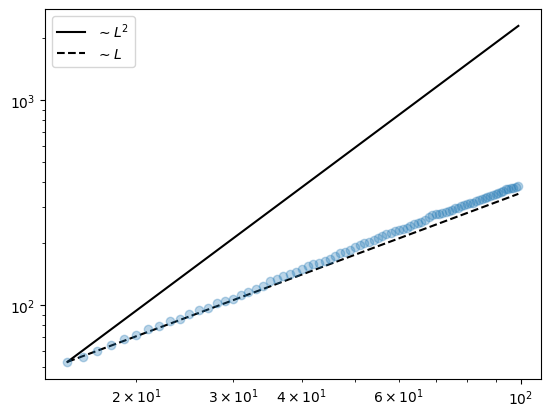

In [47]:
mean = results.mean(0)

plt.plot(Ls, mean[0]*(Ls/Ls[0])**2,c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean,'o', alpha = 0.3)
plt.legend()

#### Exponential

In [10]:
#| export
def exp_time_generator(num_samples):
    return np.random.exponential(size = num_samples)+1

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = exp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

(23.655963721815578, 500)

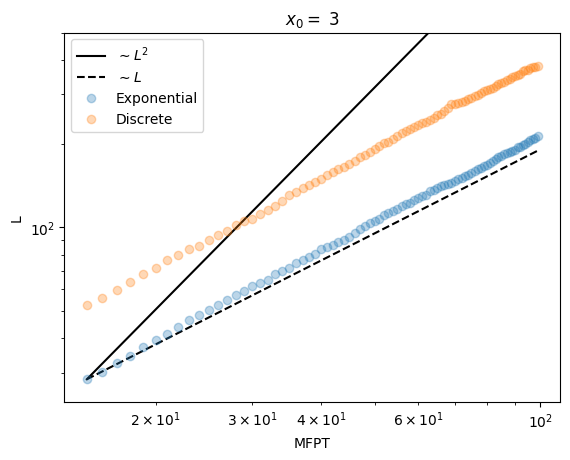

In [60]:
mean_exp = results.mean(0)

plt.plot(Ls, mean_exp[0]*(Ls/Ls[0])**2,c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean_exp[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.xlabel('MFPT'); plt.ylabel('L'); plt.title(fr'$x_0 =$ {x0}') 
plt.ylim(ymax = 500)

#### Biexponential

In [22]:
#| export
from scipy.stats.sampling import NumericalInverseHermite

class Biexp():
    def __init__(self, informed = False, **args):
        
        if not informed:
            self.w1 = args['w1']
            self.d1 = args['d1']
            self.d2 = args['d2']
        else:
            self.w1 = 2*args['x0']/args['L']
            self.d1 = 3*args['L']
            self.d2 = args['x0']        
            
        
    def pdf(self, x):
        return (self.w1/self.d1)*np.exp(-x/self.d1) + ((1 - self.w1)/ self.d2)*np.exp(-x/self.d2)
    
    def cdf(self, x):
        return 1 + (self.w1-1)*np.exp(-x/self.d2) - self.w1*np.exp(-x/self.d1)
    
    def dpdf(self, x):
        return (self.w1/self.d1**2)*np.exp(-x/self.d1) + ((1 - self.w1)/ self.d2**2)*np.exp(-x/self.d2)
    
    def sample(self, num_rn):
        return NumericalInverseHermite(self, domain=(0, np.inf)).rvs(int(num_rn))

In [13]:
#| export
def biexp_time_generator(num_samples, **sample_kwargs):
    sampler = Biexp(**sample_kwargs)
    return sampler.sample(num_samples)+1

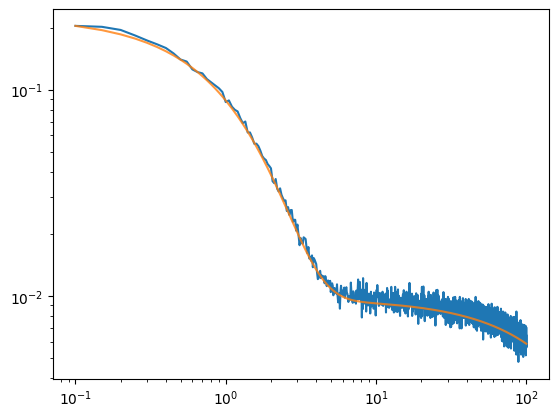

In [28]:
bi = Biexp(informed = False, w1 = 0.1, d1 = 1, d2 = 200)
bi_rng = bi.sample(int(1e6))

h, e = np.histogram(bi_rng, bins = np.linspace(0.1,100, 2000), density=True)
plt.loglog(e[:-1], h)
plt.plot(e, bi.pdf(e)*(h[0]/bi.pdf(e[0])), alpha = 0.8)

##### Uninformed

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5)
                for _ in tqdm(range(reps))), dtype = object)

mean_uninf_biexp = results.mean(0)


Text(0.5, 1.0, '$x_0 =$ 3')

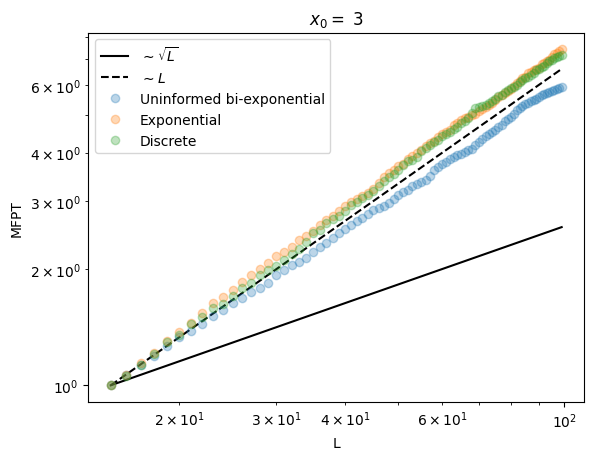

In [67]:

plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')

plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

##### Informed

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_informed_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                 traj_generator = constant_velocity_generator,
                                                                 time_sampler = biexp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

mean_biexp = results.mean(0)

Text(0.5, 1.0, '$x_0 =$ 3')

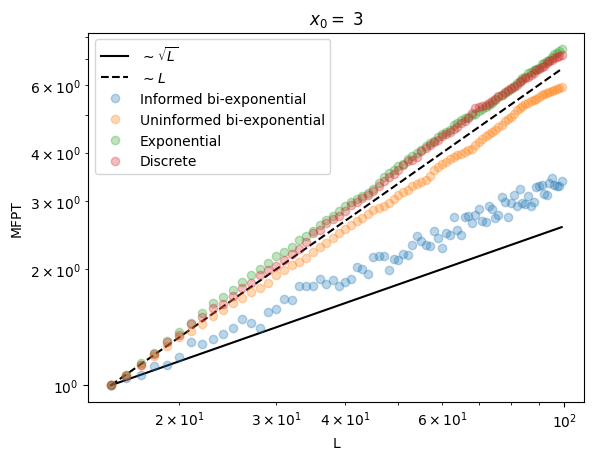

In [77]:
plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')


plt.loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Power-law

$\beta=1$, multiple repetitions

In [ ]:
N = int(1e2)
T = int(1e5)
x0 = 3
Ls = np.arange(15, 100)

beta = 1

results = np.array(Parallel(n_jobs=10)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = pdf_discrete_sample, 
                                                        pdf_func=pdf_powerlaw,
                                                        L_max = T,
                                                        beta = beta)
                for _ in tqdm(range(reps))), dtype = object)

mean_pw = results.mean(0)

Multiple $\beta$

In [ ]:
N = int(1e3)
T = int(1e5)
x0 = 3
Ls = np.arange(15, 100)

betas = np.linspace(0.1, 1.5, 10)


results = np.array(Parallel(n_jobs=len(betas))(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                traj_generator = constant_velocity_generator,
                                                                time_sampler = pdf_discrete_sample, 
                                                                pdf_func=pdf_powerlaw,
                                                                L_max = T,
                                                                beta = beta)
                for beta in tqdm(betas)), dtype = object)


mean_pw_betas = results.mean(0)

[Text(0, 0.5, 'MFPT'), Text(0.5, 0, 'L'), Text(0.5, 1.0, '$x_0 =$ 3')]

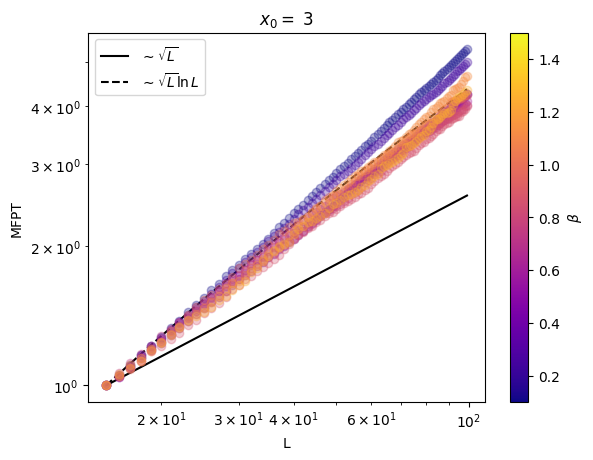

In [24]:
fig, ax = plt.subplots()
ax.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
pw_scaling = np.log(Ls)*(Ls**(1/2))
ax.plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = '--', label = r'$\sim \sqrt{L}\ln{L}$')


colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    ax.loglog(Ls, res/res[0], 'o', c = c, alpha = 0.3)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm= mcolors.Normalize(vmin=betas.min(), 
                                                                  vmax=betas.max()),
                                          cmap=plt.cm.plasma),
                    ax = ax)
cbar.set_label(r'$\beta$')

ax.legend()
plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ 3')

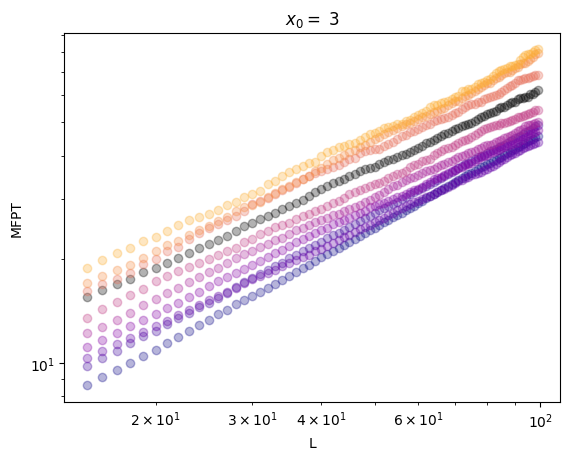

In [30]:
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c, beta in zip(results, colors, betas):
    if round(beta, 1) == 1: c = 'k'
    plt.loglog(Ls, res, 'o', c = c, alpha = 0.3)
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

Smaller $\beta$

[Text(0, 0.5, 'MFPT'), Text(0.5, 0, 'L'), Text(0.5, 1.0, '$x_0 =$ 0.02')]

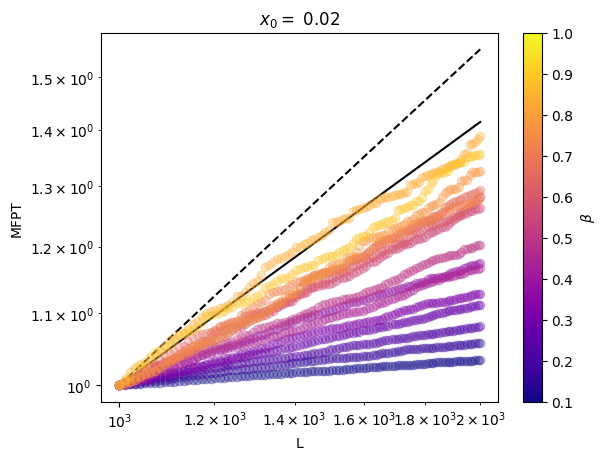

In [380]:
fig, ax = plt.subplots()
ax.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
pw_scaling = np.log(Ls)*(Ls**(1/2))
ax.plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = '--', label = r'$\sim \sqrt{L}\ln{L}$')


colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    ax.loglog(Ls, res/res[0], 'o', c = c, alpha = 0.3)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm= mcolors.Normalize(vmin=betas.min(), 
                                                                  vmax=betas.max()),
                                          cmap=plt.cm.plasma),
                    ax = ax)
cbar.set_label(r'$\beta$')
plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ 0.02')

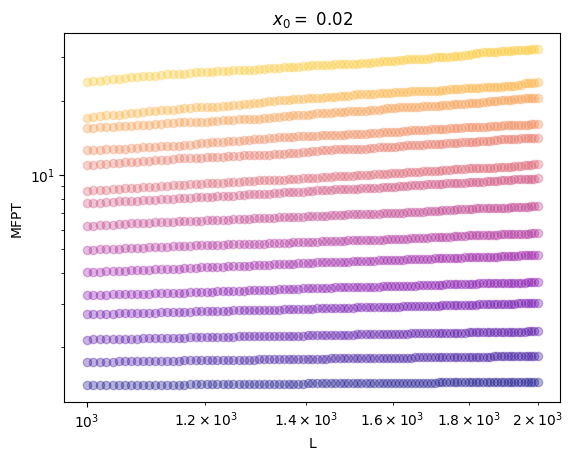

  0%|          | 0/100 [00:00<?, ?it/s]


In [378]:
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    plt.loglog(Ls, res, 'o', c = c, alpha = 0.3)
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Full comparison


Saving the data for future tests

In [33]:
a,b,c = [0]*3

In [37]:
for k in [a,b,c]:
    print(k)
    k = 12

0
0
0


In [36]:
b

0

In [271]:
names = ['discrete', 'exp', 'inf_biexp', 'uninf_biexp', 'pw']
try: 
    datas = [mean, mean_exp, mean_biexp, mean_uninf_biexp, mean_pw]
    for data, name in zip(datas, names):
        np.save('scalings_mfpt/'+name+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
else: 
    mean = np.load('scalings_mfpt/'+names[0]+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
    mean_exp = np.load('scalings_mfpt/'+names[1]+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
    mean_biexp = np.load('scalings_mfpt/'+names[2]+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
    mean_uninf_biexp = np.load('scalings_mfpt/'+names[3]+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
    mean_pw = np.load('scalings_mfpt/'+names[4]+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)
    
    

[Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ 3'),
 Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ 3')]

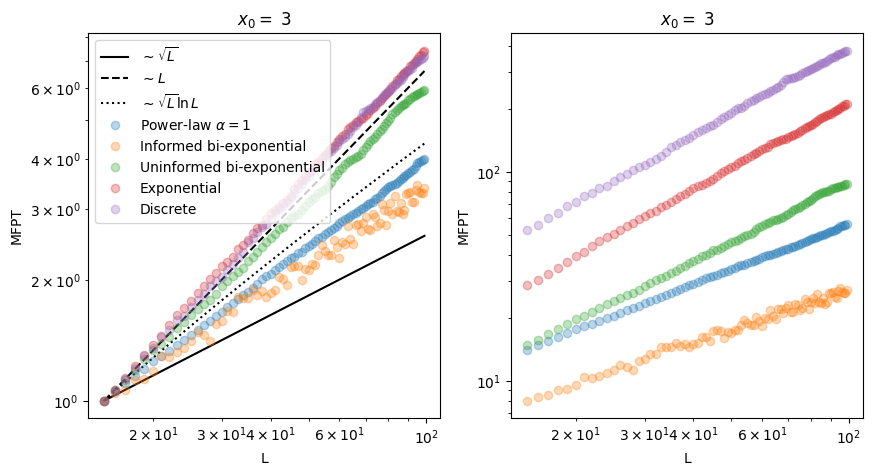

In [86]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax[0].plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Ls)*Ls**(1/2)
ax[0].plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

ax[0].loglog(Ls, mean_pw/mean_pw[0],' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
ax[0].loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[0].loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[0].loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
ax[0].loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
ax[0].legend()


ax[1].loglog(Ls, mean_pw,' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
ax[1].loglog(Ls, mean_biexp,'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[1].loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[1].loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
ax[1].loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')



plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 
                    

#| hide
### Cluster launch

In [ ]:
#| hide
x0, Ls = 3, np.arange(15, 100)
n_jobs = 10
reps = 5000

betas = np.linspace(0.1, 1.5, 10)

names = ['constant', 'exp', 'biexp_unif', 'biexp_inf', 'pw']
Ts = (np.array([1e4, 1e4, 1e4, 1e4, 1e3], dtype = int)).astype(int)
Ns = (np.array([1e3, 1e3, 1e3, 1e2, 1e4], dtype = int)).astype(int)
path = 'results_fpt/'



for idx in [3]:#range(len(names)):
    
    print(names[idx])
    
    if idx == 0: # Constant step length
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx], 
                                                 x0 = x0, Ls = Ls, 
                                                 traj_generator = rw_generator,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))



    if idx == 1: # Single exponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                 x0 = x0, Ls = Ls,
                                                 traj_generator = constant_velocity_generator,
                                                 time_sampler = exp_time_generator,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))

    if idx == 2: # Uninformed biexponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                 x0 = x0, Ls = Ls,
                                                 traj_generator = constant_velocity_generator,
                                                 time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))


    
    if idx == 3: # Informed biexponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_informed_rw)(N = Ns[idx], T = Ts[idx],
                                                          x0 = x0, Ls = Ls, 
                                                          traj_generator = constant_velocity_generator,
                                                          time_sampler = biexp_time_generator,
                                                          save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep+500}')
                                for rep in tqdm(range(reps)))

    if idx == 4: # Power law multiple betas
        for idxb, beta in enumerate(betas):
            print(round(idxb/len(betas),2))
            Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                     x0 = x0, Ls = Ls, 
                                                     traj_generator = constant_velocity_generator,
                                                     time_sampler = pdf_discrete_sample, 
                                                     pdf_func=pdf_powerlaw,
                                                     L_max = T, beta = beta,
                                                     save = path+names[idx]+f'_beta{round(beta,3)}_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                    for rep in tqdm(range(reps)))

Reading results

In [194]:
mean_fpt = []
names_read = names#[:3]+[names[-1]]*len(betas)
idxbeta = 6
for idx, name in enumerate(names_read):
    try: del collect_mean
    except: pass    

    if name == 'biexp_inf': reps = 5500
    else: reps = 500
    
    for rep in range(reps):
        if name == 'pw':
            current_m = np.load(path+name+f'_beta{round(betas[idxbeta],3)}_N_{np.log10(Ns[-1]).astype(int)}_L_{np.log10(Ts[-1]).astype(int)}_{rep}.npy')
                
        else:
            current_m = np.load(path+name+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}.npy')
            
        # current_s = np.load(path+name+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}_stats.npy')
        try:
            collect_mean = np.vstack((collect_mean, current_m))
            # collect_stat = np.vstack((collect_stat, current_s))
        except:
            collect_mean = current_m
            # collect_stat = current_s
    mean_fpt.append(collect_mean)

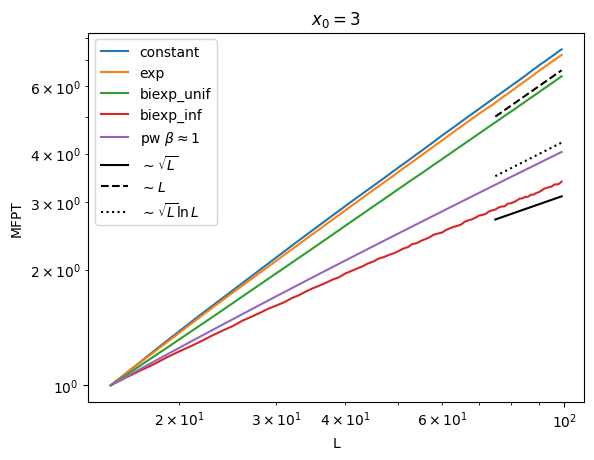

In [195]:
fig, ax = plt.subplots()
minL = 60
Lsplot = Ls[minL:]
for m, n  in zip(mean_fpt, names_read):
    if n == 'pw': n = r'pw $\beta \approx 1$'
    mean = m.mean(0)#[minL:]
    ax.plot(Ls, mean/mean[0], label = n)


ax.plot(Lsplot, 2.7*(Lsplot/Lsplot[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax.plot(Lsplot, 5*(Lsplot/Lsplot[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Lsplot)*Lsplot**(1/2)
ax.plot(Lsplot, 3.5*pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

plt.setp(ax, xscale = 'log', yscale = 'log', xlabel = 'L', ylabel = 'MFPT', title = fr'$x_0 = {x0}$')
ax.legend()

In [164]:
mean_fpt_pw = []
name = 'pw'#[:3]+[names[-1]]*len(betas)

for idxbeta, beta in enumerate(betas):
    try: del collect_mean
    except: pass    

        
    for rep in range(reps):
        current_m = np.load(path+name+f'_beta{round(betas[idxbeta],3)}_N_{np.log10(Ns[-1]).astype(int)}_L_{np.log10(Ts[-1]).astype(int)}_{rep}.npy')
       
        try:
            collect_mean = np.vstack((collect_mean, current_m))
            # collect_stat = np.vstack((collect_stat, current_s))
        except:
            collect_mean = current_m
            # collect_stat = current_s
    mean_fpt_pw.append(collect_mean)

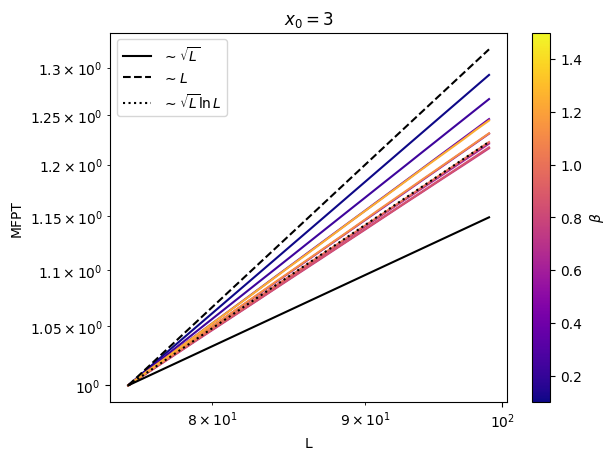

In [170]:
fig, ax = plt.subplots()
minL = 60
Lsplot = Ls[minL:]
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for m, c  in zip(mean_fpt_pw, colors):
    mean = m.mean(0)[minL:]
    ax.plot(Lsplot, mean/mean[0], c = c)


ax.plot(Lsplot, (Lsplot/Lsplot[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax.plot(Lsplot, (Lsplot/Lsplot[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Lsplot)*Lsplot**(1/2)
ax.plot(Lsplot, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

plt.setp(ax, xscale = 'log', yscale = 'log', xlabel = 'L', ylabel = 'MFPT', title = fr'$x_0 = {x0}$')
ax.legend()
cbar = fig.colorbar(plt.cm.ScalarMappable(norm= mcolors.Normalize(vmin=betas.min(), 
                                                                  vmax=betas.max()),
                                          cmap=plt.cm.plasma),
                    ax = ax)
cbar.set_label(r'$\beta$')

In [175]:
fit = []
for m, c  in zip(mean_fpt_pw, colors):
    mean = m.mean(0)[minL:]
    fit.append(np.polyfit(np.log(Lsplot), np.log(mean/mean[0]), deg=1)[0])

[Text(0.5, 0, '$\\beta$'), Text(0, 0.5, 'Fit long time MFPT')]

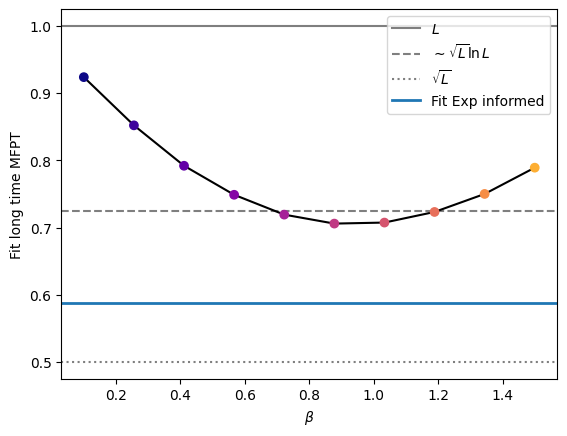

In [207]:
# Approx fit log(L)
app_log =  np.polyfit(np.log(Lsplot), np.log(pw_scaling/pw_scaling[0]), deg=1)[0]

# Fit informed
mftp_inf = mean_fpt[-2].copy()
mean_inf = mftp_inf.mean(0)[minL:]
fit_informed = np.polyfit(np.log(Lsplot), np.log(mean_inf/mean_inf[0]), deg=1)[0]

# Plot
fig, ax = plt.subplots()
# plot powerlaw
ax.plot(betas, fit, c = 'k')
ax.scatter(betas, fit, c = colors[:len(betas)], zorder = 10)
for line, name, ls in zip([1, app_log, 1/2], [r'$L$', r'$\sim \sqrt{L}\ln{L}$', r'$\sqrt{L}$'], ['-', '--',':']):
    ax.axhline(line, label = name, ls = ls, alpha = 0.5, c = 'k')
# plot informed    
ax.axhline(fit_informed, label = 'Fit Exp informed', lw = 2)
    
ax.legend()
plt.setp(ax, xlabel = r'$\beta$', ylabel = 'Fit long time MFPT')

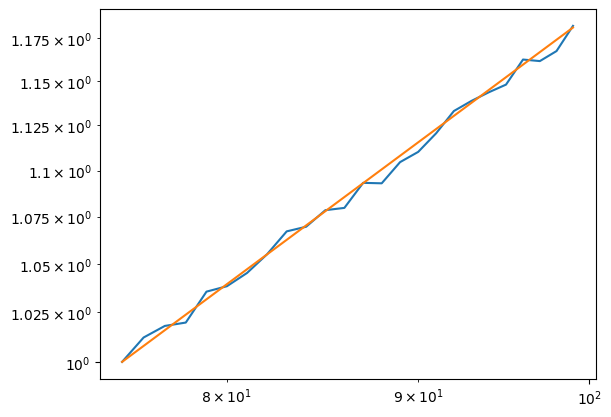

In [206]:
minL = 60
mean_inf = mftp_inf.mean(0)[minL:]
Lsplot = Ls[minL:]
plt.loglog(Lsplot, mean_inf/mean_inf[0])
plt.loglog(Lsplot, (Lsplot/Lsplot[0])**(0.6))

## 2D (not conclusive results)

In [101]:
#| export
def constant_velocity_generator_2D(N, # Number of trajectories
                                   T, # Length of trajectories
                                   time_sampler, # Sampler of time of constant velocity
                                   velocity = 1, # Velocity
                                   **sample_args # Optional arguments for the sampler
                               ):
    ''' Given a sampler for length of time steps, generates a 2D trajectory considering a constant
    velocity in the sampled times. After each time step, we sample a new direction. '''
    
    trajs_x = np.zeros((N, T))
    trajs_y = np.zeros((N, T))
    
    for idxN in (range(N)):        
        
        times = time_sampler(num_samples = T+1, **sample_args).astype(int)
        
        # If we have too many times (e.g. because we sampled big times),
        # we cut the times vector with max_t
        max_t = np.argwhere(np.cumsum(times) > T+1).flatten()
        if len(max_t) > 0:
            max_t = max_t[0]
        else: max_t = T+1
        
        traj_x = np.array([0])
        traj_y = np.array([0])
        cumsum = 0
        for time in times[:max_t+1]:
            angle = np.random.rand()*2*np.pi
            
            segment_x = np.cos(angle)*np.arange(1, min(time+1, T+1))+traj_x[-1]
            segment_y = np.sin(angle)*np.arange(1, min(time+1, T+1))+traj_y[-1]
            
            traj_x = np.append(traj_x, segment_x)
            traj_y = np.append(traj_y, segment_y)
            
            cumsum += len(segment_x)
            if cumsum > T:
                break

        trajs_x[idxN] = traj_x[:T]
        trajs_y[idxN] = traj_y[:T]        
    
    return trajs_x, trajs_y
    

In [73]:
N = 5; T = 150
trajs_lw_x, trajs_lw_y = constant_velocity_generator_2D(N, T, time_sampler = lw_step, beta = 1)

def single_steps(num_samples):
    return np.ones(num_samples)

trajs_rw_x, trajs_rw_y = constant_velocity_generator_2D(N, T, time_sampler = single_steps, velocity = 1.2)


Finished generating trajectories
Finished generating trajectories


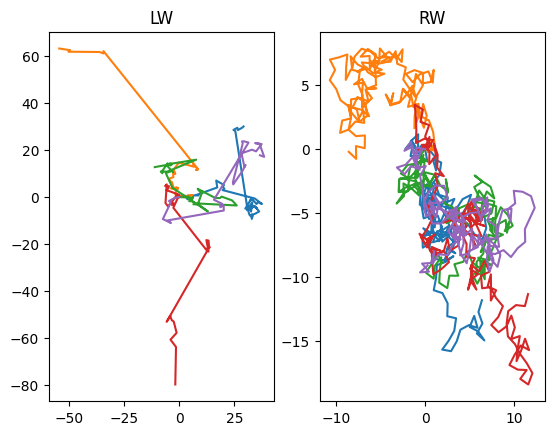

In [81]:
fig, ax = plt.subplots(1, 2)
for x, y in zip(trajs_lw_x, trajs_lw_y):
    ax[0].plot(x, y)
ax[0].set_title('LW')
for x, y in zip(trajs_rw_x, trajs_rw_y):
    ax[1].plot(x, y)
ax[1].set_title('RW');

### MFPT calculator

In [177]:
#| export
from typing import Callable

def mfpt_rw_2D(N:int, # Number of trajectories
               T:int, # Lengths of trajectories
               x0:list, # Starting point of walk (in 2d)
               Ls:list, # Boundary position
               traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
               max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
               **args_generator # Arguments of the trajectory generator
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 in 2D'''



    # Debug
    # N = 5; T = 50; x0 = [3,3]; Ls = [99]; max_loop = 40

    trajs_x, trajs_y = traj_generator(N, T, **args_generator)
    
    trajs_x += x0[0]
    trajs_y += x0[1]

    mfpt = []
    for L in tqdm_term(Ls):   

        first_passage_x = np.argmax((trajs_x < -L**2) | (trajs_x > L), axis = 1).astype(float)
        first_passage_y = np.argmax((trajs_y < -L**2) | (trajs_y > L), axis = 1).astype(float)

        # Needed transformation to correctly find the minimum considering the presence of zeros
        first_passage_x[first_passage_x == 0] = np.nan
        first_passage_y[first_passage_y == 0] = np.nan    
        first_passage = np.nanmin(np.vstack((first_passage_x, first_passage_y)), axis = 0)
        first_passage[np.isnan(first_passage)] = 0

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = (trajs_x[non_passed, -1], trajs_x[non_passed, -1])    
        while len(non_passed) > 0 and n_loop < max_loop:


            # print('inside')
            trajs_upd_x = rw_generator(len(non_passed),T) + last_non_passed[0][..., np.newaxis]
            trajs_upd_y = rw_generator(len(non_passed),T) + last_non_passed[1][..., np.newaxis]


            # Finding the FPT of the new trajectories
            first_upd_x = np.argmax((trajs_upd_x < -L**2) | (trajs_upd_x > L), axis = 1).astype(float)
            first_upd_y = np.argmax((trajs_upd_y < -L**2) | (trajs_upd_y > L), axis = 1).astype(float)

            # Needed transformation to correctly find the minimum considering the presence of zeros
            first_upd_x[first_upd_x == 0] = np.nan
            first_upd_y[first_upd_y == 0] = np.nan    
            first_upd = np.nanmin(np.vstack((first_upd_x, first_upd_y)), axis = 0)
            first_upd[np.isnan(first_upd)] = 0

            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = (trajs_upd_x[upd_non_passed, -1], trajs_upd_y[upd_non_passed, -1])

            n_loop += 1        

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        if len(non_passed) > 0: print(round(len(non_passed)/len(non_passed),2))
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
    return mfpt
    

### Results

#### Discrete walking
In this case we are already doing constant velocities, hence we can use the generator below:

In [ ]:
N = int(1e4)
T = int(1e2)
x0 = [1, 1]
Ls = np.linspace(5, 150, 20)

reps = 10
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                           traj_generator = constant_velocity_generator_2D,
                                                           time_sampler = single_steps)
                for _ in tqdm(range(reps))), dtype = object)

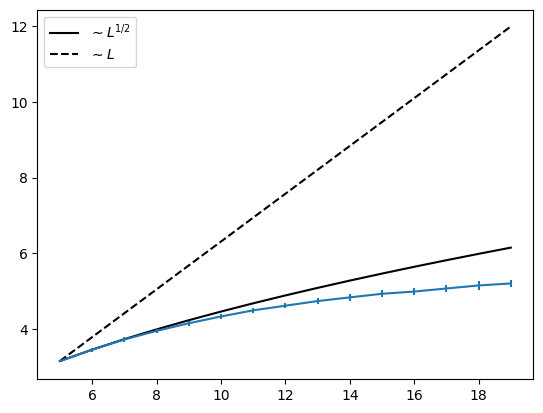

In [164]:
mean = results.mean(0)


plt.plot(Ls, mean[0]*(Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim L^{1/2}$')
plt.plot(Ls, mean[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
# plt.loglog(Ls, mean,'o', alpha = 0.8)
plt.errorbar(Ls, mean, yerr = results.astype(float).std(0))

plt.legend()

# plt.xlim(xmax = 150)

### Exponential

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = [0.5, 0.5]
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls,
                                                           traj_generator = constant_velocity_generator_2D,
                                                           time_sampler = exp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

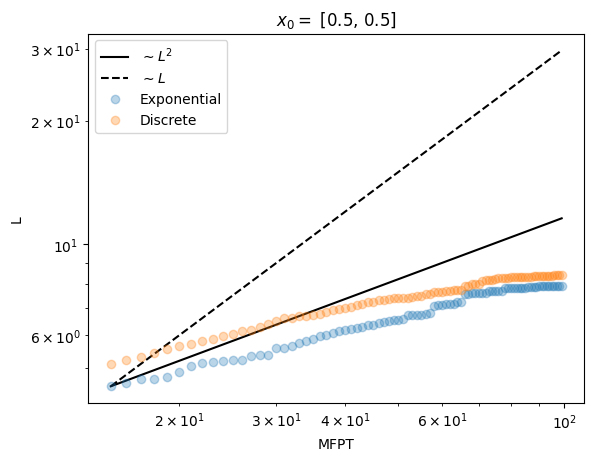

In [119]:
mean_exp = results.mean(0)

plt.plot(Ls, mean_exp[0]*(Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean_exp[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.xlabel('MFPT'); plt.ylabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Biexponential

#### Uninformed

In [ ]:
N = int(1e3)
T = int(1e5)
x0 = [0.5, 0.5]
Ls = np.arange(5, 30)

reps = 20*4
results = np.array(Parallel(n_jobs=5)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator_2D,
                                                        time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5)
                for _ in tqdm(range(reps))), dtype = object)

mean_uninf_biexp = results.mean(0)


Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

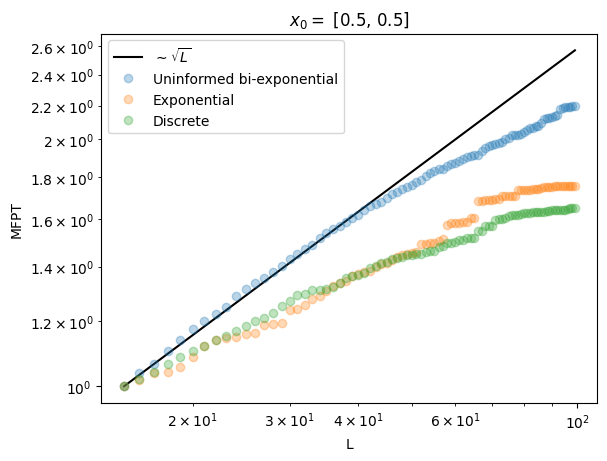

In [137]:

plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
# plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')

plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

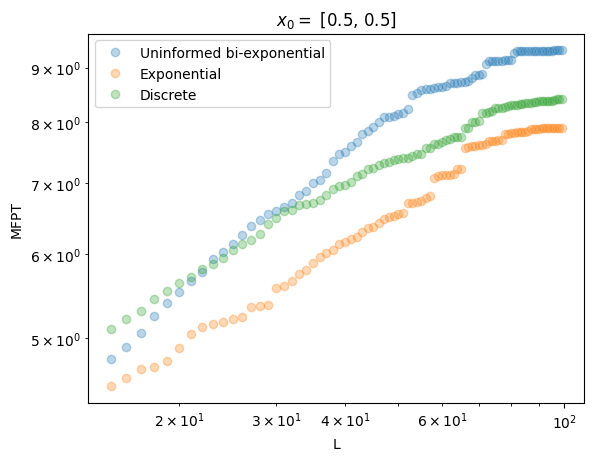

In [131]:
plt.loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

#### Informed

In [124]:
#| export
from typing import Callable

def mfpt_informed_rw_2D(N:int, # Number of trajectories
                        T:int, # Lengths of trajectories
                        x0:list, # Starting point of walk (in 2d)
                        Ls:list, # Boundary position
                        traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
                        max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
                        **args_generator # Arguments of the trajectory generator
                       ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 in 2D'''



    # Debug
    # N = 5; T = 50; x0 = [3,3]; Ls = [99]; max_loop = 40


    mfpt = []
    for L in tqdm_term(Ls):   
        
        
        trajs_x, trajs_y = traj_generator(N, T, time_sampler = time_sampler, x0 = x0, L = L, informed = True)        
        trajs_x += x0[0]
        trajs_y += x0[1]

        first_passage_x = np.argmax((trajs_x < 0) | (trajs_x > L), axis = 1).astype(float)
        first_passage_y = np.argmax((trajs_y < 0) | (trajs_y > L), axis = 1).astype(float)

        # Needed transformation to correctly find the minimum considering the presence of zeros
        first_passage_x[first_passage_x == 0] = np.nan
        first_passage_y[first_passage_y == 0] = np.nan    
        first_passage = np.nanmin(np.vstack((first_passage_x, first_passage_y)), axis = 0)
        first_passage[np.isnan(first_passage)] = 0

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = (trajs_x[non_passed, -1], trajs_x[non_passed, -1])    
        while len(non_passed) > 0 and n_loop < max_loop:


            # print('inside')
            trajs_upd_x = rw_generator(len(non_passed),T) + last_non_passed[0][..., np.newaxis]
            trajs_upd_y = rw_generator(len(non_passed),T) + last_non_passed[1][..., np.newaxis]


            # Finding the FPT of the new trajectories
            first_upd_x = np.argmax((trajs_upd_x < 0) | (trajs_upd_x > L), axis = 1).astype(float)
            first_upd_y = np.argmax((trajs_upd_y < 0) | (trajs_upd_y > L), axis = 1).astype(float)

            # Needed transformation to correctly find the minimum considering the presence of zeros
            first_upd_x[first_upd_x == 0] = np.nan
            first_upd_y[first_upd_y == 0] = np.nan    
            first_upd = np.nanmin(np.vstack((first_upd_x, first_upd_y)), axis = 0)
            first_upd[np.isnan(first_upd)] = 0

            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = (trajs_upd_x[upd_non_passed, -1], trajs_upd_y[upd_non_passed, -1])

            n_loop += 1        

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
    return mfpt
    

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_informed_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                 traj_generator = constant_velocity_generator,
                                                                 time_sampler = biexp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

mean_biexp = results.mean(0)

In [ ]:
plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')


plt.loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Power-law

In [ ]:
N = int(1e3)
T = int(1e4)
x0 = [0.5, 0.5]
Ls = np.arange(15, 100)

reps = 20
beta = 1

results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = constant_velocity_generator_2D,
                                                        time_sampler = pdf_discrete_sample, 
                                                           pdf_func=pdf_powerlaw,
                                                           L_max = T, beta = beta,)
                for _ in tqdm(range(reps))), dtype = object)

mean_pw = results.mean(0)

[Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]'),
 Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')]

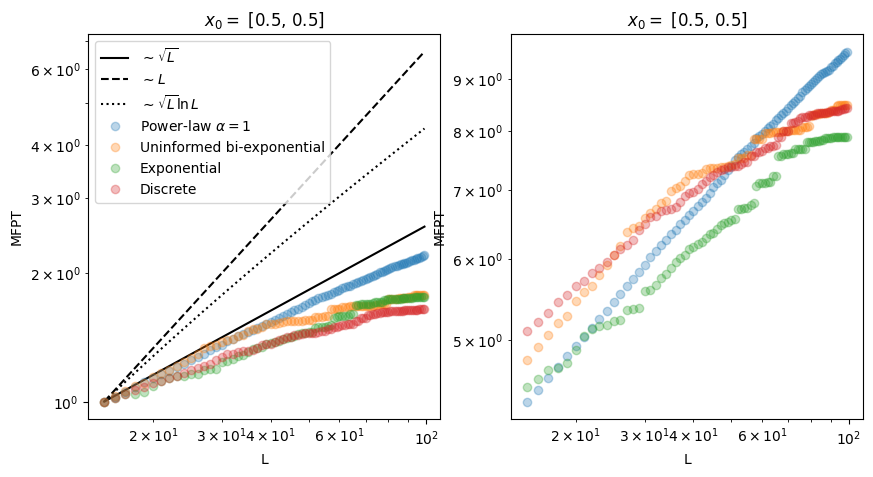

In [128]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax[0].plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Ls)*Ls**(1/2)
ax[0].plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

ax[0].loglog(Ls, mean_pw/mean_pw[0],' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
# ax[0].loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[0].loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[0].loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
ax[0].loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
ax[0].legend()


ax[1].loglog(Ls, mean_pw,' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
# ax[1].loglog(Ls, mean_biexp,'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[1].loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[1].loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
ax[1].loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')



plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 
                    

# NBDEV Export

In [9]:
from nbdev import nbdev_export; nbdev_export()